# Momentum Assignment

### Raghav Srivastava
### GTID: 903851312

In [56]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category = FutureWarning)
import time
import os
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from functools import reduce
from IPython.display import Markdown, display
from concurrent.futures import ThreadPoolExecutor
os.chdir("/Users/raghav/Documents/Momentum")

### Auxiliary Functions

In [57]:
def plotSeriesFromDataFrame(dataFrame, title=None, xLabel="Date", yLabel="Level",
                            legendLoc="best", rotateXTicks=True,
                            legendOutside=False):
    
    plt.figure(figsize=(10, 6), dpi=400)
    for column in dataFrame.columns:
        plt.plot(dataFrame.index, dataFrame[column], label=column, linestyle="-")

    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel(yLabel, fontsize=12)
    plt.title(title, fontsize=14)
    
    # Adjust the range to step by 5
    years_to_keep = range(dataFrame.index.year.min(), dataFrame.index.year.max() + 1, 5)
    
    # Set the x-ticks to only the years that we want to keep
    plt.xticks([pd.Timestamp(year, 1, 1) for year in years_to_keep], years_to_keep)
    
    if legendOutside:
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False,
                   bbox_transform=plt.gca().transAxes)
    else:
        plt.legend(loc=legendLoc, fontsize=10)
    
    plt.grid(True)
    
    if rotateXTicks:
        plt.xticks(rotation=45)
    
    plt.show()

In [58]:
def tTest(df, portfolio):
    tTestResults = {}
    for column in df.columns:
        tStatistic, pValue = stats.ttest_1samp(df[column].dropna(), 0)
        tTestResults[column] = {"p-value of t-test for {}".format(portfolio): pValue.round(3)}
    tTestResults = pd.DataFrame(tTestResults)
    return tTestResults

### 0.1. Reading and Processing CRSP Monthly Data

In [59]:
crsp = pd.read_csv("crsp_monthly.csv")[["RET", "DLRET", "PRC", "SHRCD", "PERMNO", "date"]]
crsp.columns = crsp.columns.str.lower()
crsp["ret"] = pd.to_numeric(crsp["ret"], errors="coerce")
crsp["dlret"] = pd.to_numeric(crsp["dlret"], errors="coerce")
crsp["prc"] = pd.to_numeric(crsp["prc"], errors="coerce")
crsp["shrcd"] = pd.to_numeric(crsp["shrcd"], errors="coerce")
crsp["permno"] = pd.to_numeric(crsp["permno"], errors="coerce")

crsp["prc"] = abs(crsp["prc"]) 

crsp = crsp[crsp["shrcd"].isin([10, 11])].set_index("date")
crsp.index = pd.to_datetime(crsp.index)
crsp.index = pd.to_datetime(crsp.index).to_period("M").to_timestamp()

crsp["ret"] = crsp["ret"].fillna(crsp["dlret"])
crsp["ret"] = crsp["ret"].replace([np.inf, -np.inf], 0)
crsp["ret"] = crsp["ret"].fillna(0)


crsp = crsp.drop(columns = ["dlret", "shrcd"])
crsp = crsp.sort_index()

### 0.2. Initial Strategy

#### Calculating Past and Future Returns Company-Wise

In [61]:
def calculateReturns(company):
    
    company = company[1]

    company["1+ret"] = company["ret"] + 1
    company["pastYearRet"] = company["1+ret"].rolling(window=13).apply(lambda x: np.prod(x[:-1]), raw=True) -1
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
    company["future1MonthRet"] = company["1+ret"].rolling(window=indexer, min_periods=1).apply(lambda x: np.prod(x[1:]), raw=True) -1
    company["future1MonthRet"].iloc[-1:] = np.nan
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
    company["future3MonthRet"] = company["1+ret"].rolling(window=indexer, min_periods=1).apply(lambda x: np.prod(x[1:]), raw=True) -1
    company["future3MonthRet"].iloc[-3:] = np.nan
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=7)
    company["future6MonthRet"] = company["1+ret"].rolling(window=indexer, min_periods=1).apply(lambda x: np.prod(x[1:]), raw=True) -1
    company["future6MonthRet"].iloc[-6:] = np.nan
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=13)
    company["future12MonthRet"] = company["1+ret"].rolling(window=indexer, min_periods=1).apply(lambda x: np.prod(x[1:]), raw=True) -1
    company["future12MonthRet"].iloc[-12:] = np.nan
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=61)
    company["future60MonthRet"] = company["1+ret"].rolling(window=indexer, min_periods=1).apply(lambda x: np.prod(x[1:]), raw=True) -1
    company["future60MonthRet"].iloc[-60:] = np.nan
    
    
    company = company[company["prc"]>=5]
    company = company.dropna(subset = "pastYearRet")
    
    company = company.drop(columns = ["prc", "1+ret",])
    
    return company


start_time = time.time()

crspCompanyWise = list(crsp.groupby("permno"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(calculateReturns, crspCompanyWise))
crsp = pd.concat(results)

elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))

This took 4 minutes 33 seconds


#### Constructing Decile Portfolios Month-Wise

In [62]:
def constructPortfolios(month):
    month = month[1]

    month["decile"] = pd.qcut(month["pastYearRet"], q=10, labels=False) + 1
    month["UorD"] = ["up" if x == 10 else "down" if x == 1 else np.nan for x in month["decile"]]
    
    return month



start_time = time.time()

crspMonthWise = list(crsp.groupby("date"))
with ThreadPoolExecutor() as executor:
    results = list(executor.map(constructPortfolios, crspMonthWise))
crsp = pd.concat(results)

elapsed_time = time.time() - start_time
print("This took {} minutes {} seconds".format(int(elapsed_time//60), round(elapsed_time%60)))

This took 0 minutes 1 seconds


#### Calculating Up, Down and UMD Returns

In [63]:
up = crsp[crsp["UorD"]=="up"]
down = crsp[crsp["UorD"]=="down"]

up = up.groupby("date")[["future1MonthRet", 
                         "future3MonthRet",
                         "future6MonthRet",
                         "future12MonthRet",
                         "future60MonthRet"]].mean()

down = down.groupby("date")[["future1MonthRet", 
                         "future3MonthRet",
                         "future6MonthRet",
                         "future12MonthRet",
                         "future60MonthRet"]].mean()


UMD = up-down

### 0.2.1. Analyzing strategy Performance and Backtesting

#### Average Returns

In [64]:
upAverage = up.mean().to_frame().rename(columns = {0:"up"}).T.round(3)
downAverage = down.mean().to_frame().rename(columns = {0:"down"}).T.round(3)
UMDAverage = UMD.mean().to_frame().rename(columns = {0:"UMD"}).T.round(3)
Table1 = pd.concat([upAverage, downAverage, UMDAverage])


header = "### Table 1: Average Future Returns for Up, Down and UMD Portfolios"
display(Markdown(header))
display(Table1)

### Table 1: Average Future Returns for Up, Down and UMD Portfolios

,future1MonthRet,future3MonthRet,future6MonthRet,future12MonthRet,future60MonthRet
up,0.016,0.047,0.087,0.156,0.811
down,0.003,0.015,0.036,0.108,0.907
UMD,0.013,0.032,0.052,0.049,-0.097


#### t-test p-values (probablity of average returns being different from zero)

In [65]:
tUp = tTest(up, "up")
tDown = tTest(down, "down")
tUMD = tTest(UMD, "UMD")

tTestResults = pd.concat([tUp, tDown, tUMD])


header = "### p-values of t-test (probablity of average returns being different from zero) for Up, Down and UMD Portfolios"
display(Markdown(header))
display(tTestResults)

### p-values of t-test (probablity of average returns being different from zero) for Up, Down and UMD Portfolios

,future1MonthRet,future3MonthRet,future6MonthRet,future12MonthRet,future60MonthRet
p-value of t-test for up,0.000,0.000,0.0,0.0,0.0
p-value of t-test for down,0.214,0.006,0.0,0.0,0.0
p-value of t-test for UMD,0.000,0.000,0.0,0.0,0.0


### Short Term and Long Term Performance of Winner and Loser Stocks

##### In the short term, "up" stocks, or winners, tend to outperform "down" stocks, or losers. Specifically, the average 1-month return for the winners is 0.016, which decreases slightly for the 3-month return to 0.047, and increases again to 0.087 for the 6-month period. This performance indicates a continuing advantage for winner stocks over the span of half a year. The UMD portfolio, which involves a long position in the "up" stocks and a short position in the "down" stocks, also shows a consistent performance with returns growing from 0.013 at the 1-month mark to 0.052 at the 12-month horizon. This reinforces the notion of momentum in stock performance where winners continue to perform well relative to losers in the short term.


##### In the long term, however, the trend for winners is markedly different. Over a 60-month period, the return on the "up" stocks drops significantly to 0.811, indicating a substantial reduction in the outperformance observed in the shorter time frames. On the other hand, "down" stocks exhibit a remarkable average return of 0.907 over the same 60-month period, suggesting a reversal of fortune where loser stocks surpass winner stocks in terms of return. This could be reflective of a mean reversion strategy where the stocks that previously underperformed recover over a longer time horizon. The UMD portfolio registers a negative return (-0.097) over 60 months, further highlighting that the initial outperformance of winners does not persist in the long run and that there might be a shift in the market that favors the initially underperforming stocks over a 5-year period.

#### Reading and Processing Fama-French Five Factor Data

In [66]:
fama = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", usecols=[0, 1, 2, 3, 4, 5], skiprows=range(0, 3), nrows=725 - 3)    
fama["Unnamed: 0"] = fama["Unnamed: 0"].astype(str)
fama["date"] = pd.to_datetime(fama["Unnamed: 0"], format="%Y%m")
fama.drop("Unnamed: 0", axis=1, inplace=True)
fama.set_index("date", inplace=True)

#### Regression of Portfolio Returns with Fama-French 5 Factors

In [67]:
def regressionWithFamaFrenchFactors(df, portfolio, fama):

    df = df.merge(fama, left_index = True, right_index = True, how = "inner")
    df = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    Y = df["future1MonthRet"]
    X = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    
    params = {"intercept": model.params["const"].round(3),
              "intercept_pValue": model.pvalues["const"].round(3)}
    result = {}
    result[portfolio] = params
    result = pd.DataFrame(result).T
    return result
    
regressionResults = pd.concat([regressionWithFamaFrenchFactors(up[["future1MonthRet"]], "up", fama),
                                regressionWithFamaFrenchFactors(down[["future1MonthRet"]], "down", fama),
                                regressionWithFamaFrenchFactors(UMD[["future1MonthRet"]], "UMD", fama)])


header = "### Table 2: Intercepts and Intercept p-values for regression of Up, Down and UMD 1 Month Returrns with Fama-French Five Factors"
display(Markdown(header))
display(regressionResults)

### Table 2: Intercepts and Intercept p-values for regression of Up, Down and UMD 1 Month Returrns with Fama-French Five Factors

,intercept,intercept_pValue
up,0.017,0.000
down,0.001,0.623
UMD,0.016,0.000


### Significance of the Momentum Strategy

##### The momentum strategy, as depicted by the UMD (Up Minus Down) portfolio's performance, capitalizes on the tendency of winning stocks to continue their ascent and losing stocks to persist in their decline over the short to medium term. This strategy, in the case presented, yields positive returns across 1, 3, 6, and 12-month horizons, which suggests that investors could potentially achieve excess returns by taking a long position in recently outperforming stocks while simultaneously shorting the underperformers. Notably, the "Up" component of the portfolio contributes more significantly to the momentum strategy’s alpha in these time frames, consistently showing higher returns than the "Down" stocks. However, the "Down" stocks have a dramatic upswing in the long-term 60-month horizon, surpassing the "Up" stocks, which implies that over extended periods, the "Down" component may have a greater influence on the performance due to a mean-reversion effect that counters the initial momentum-based alpha.

#### Plotting 1 Month Cumulative Returns of the Up, Down and UMD Portfolios

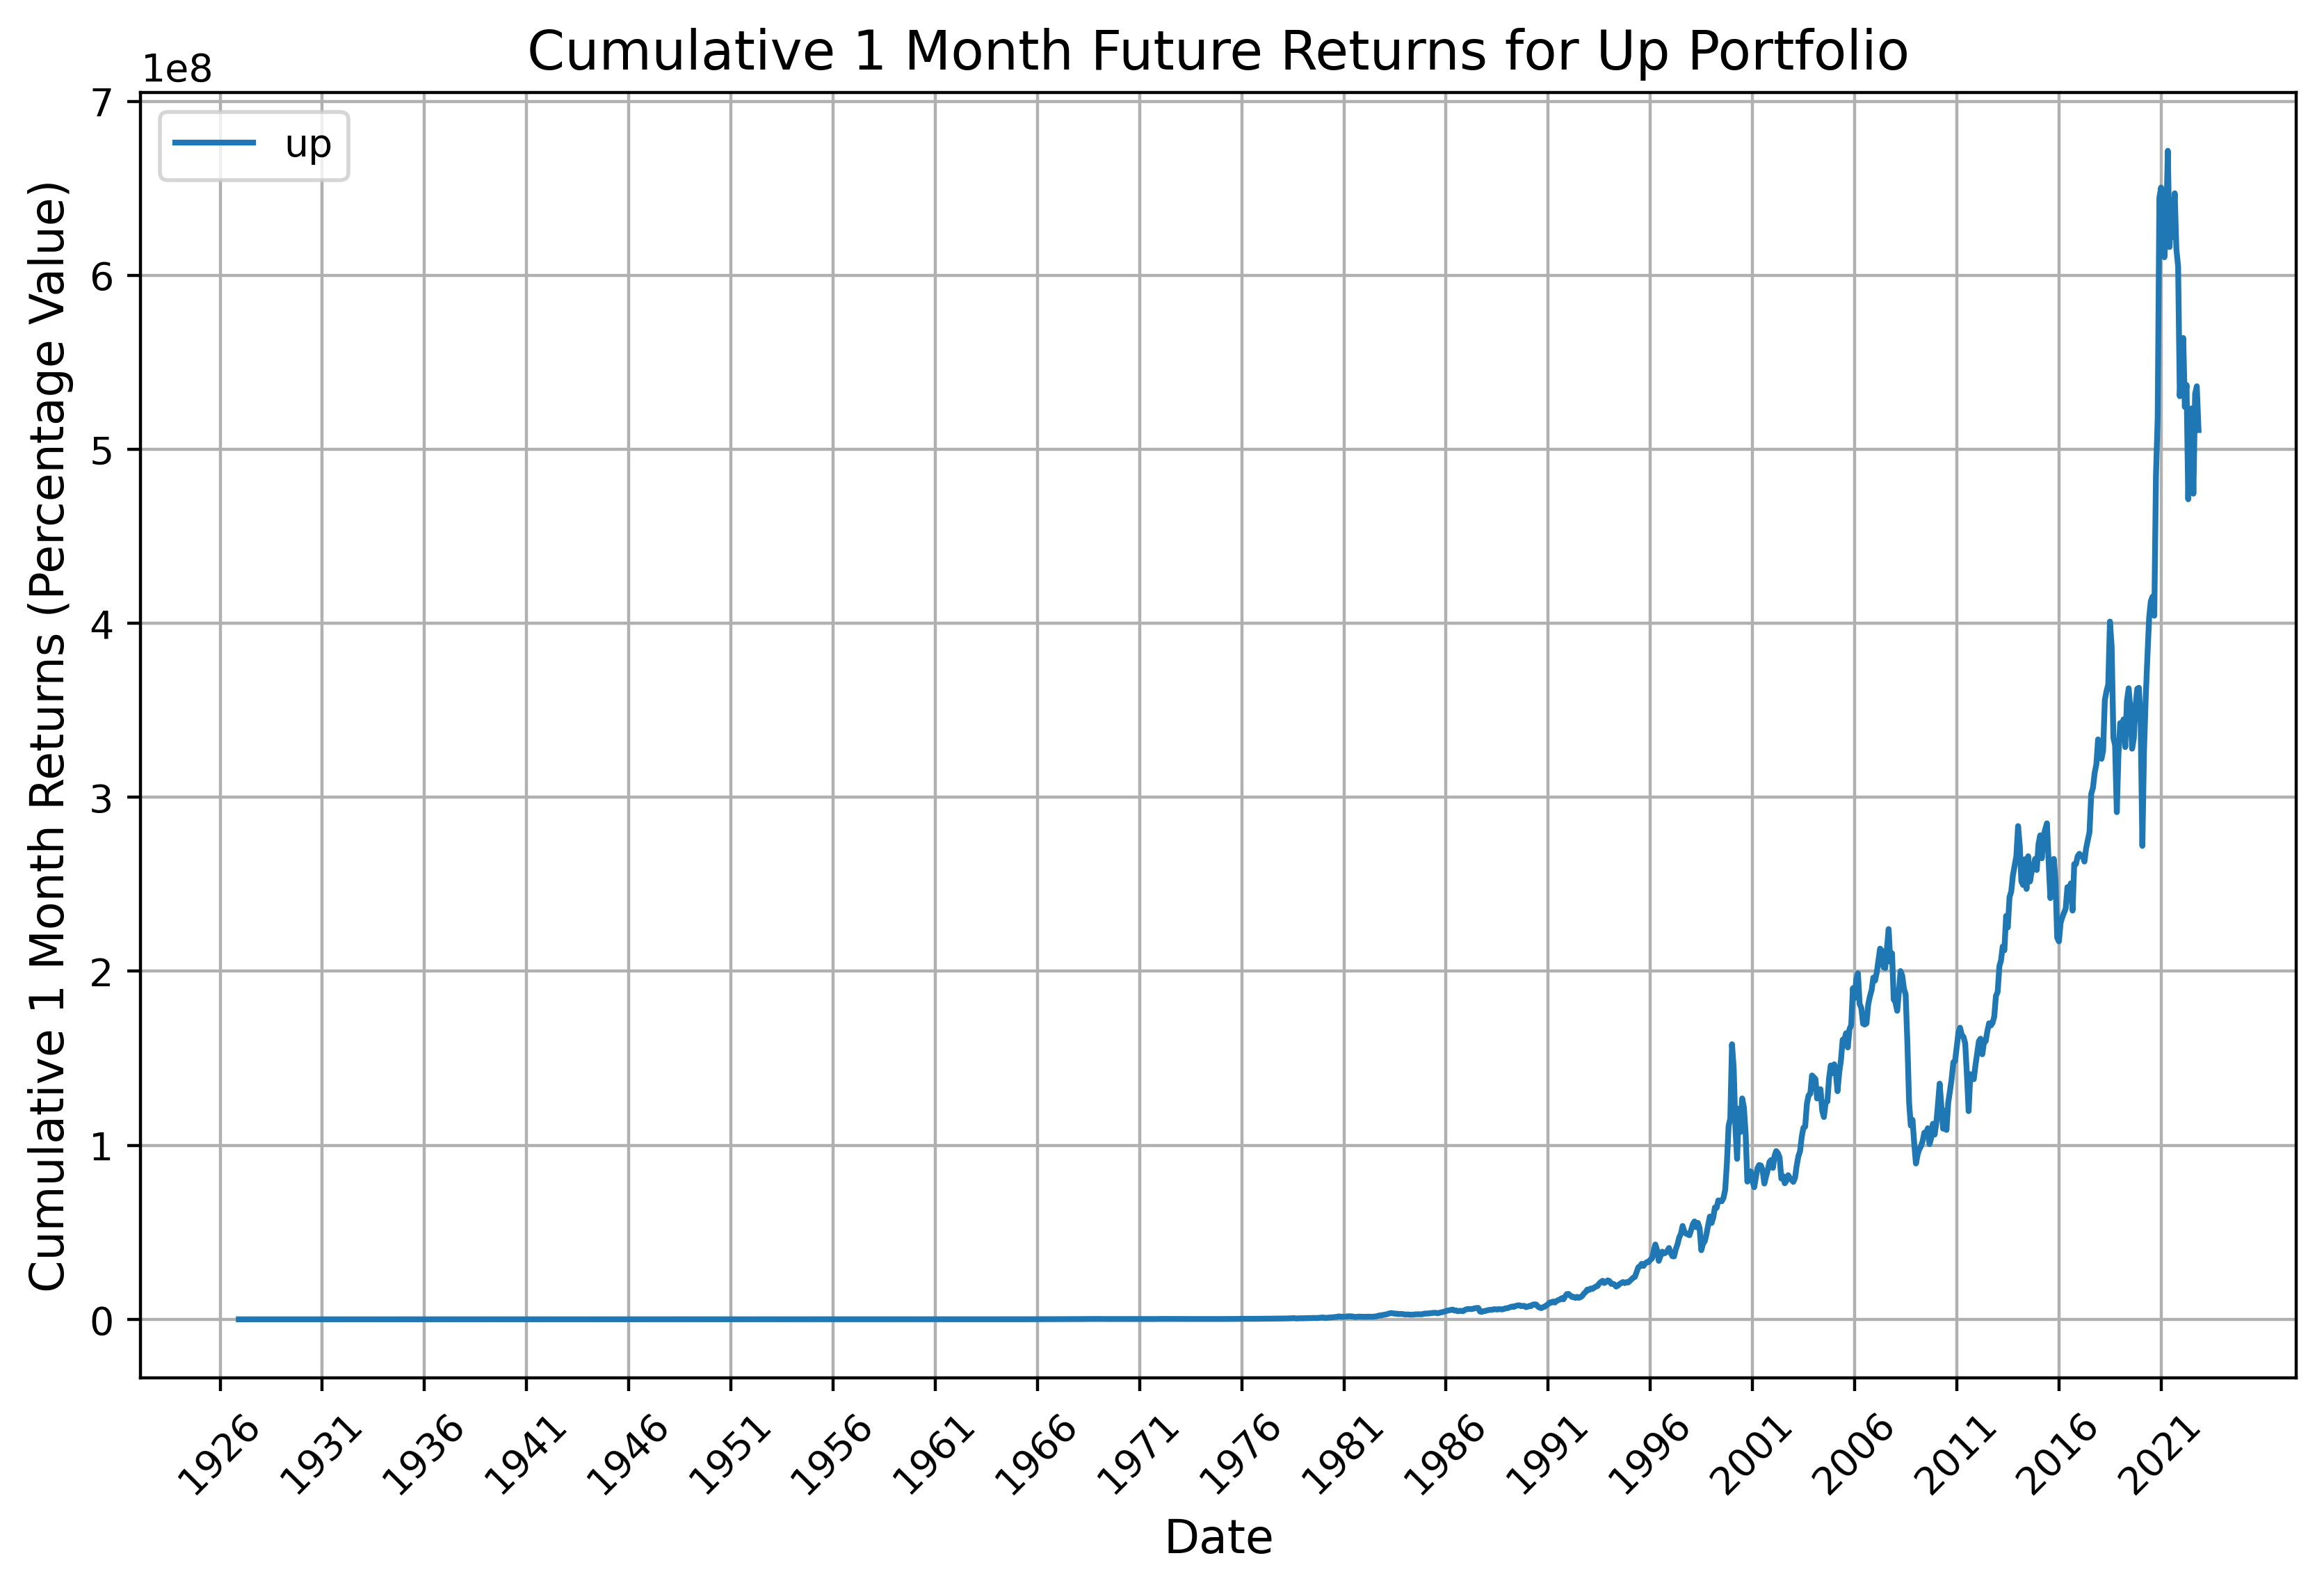

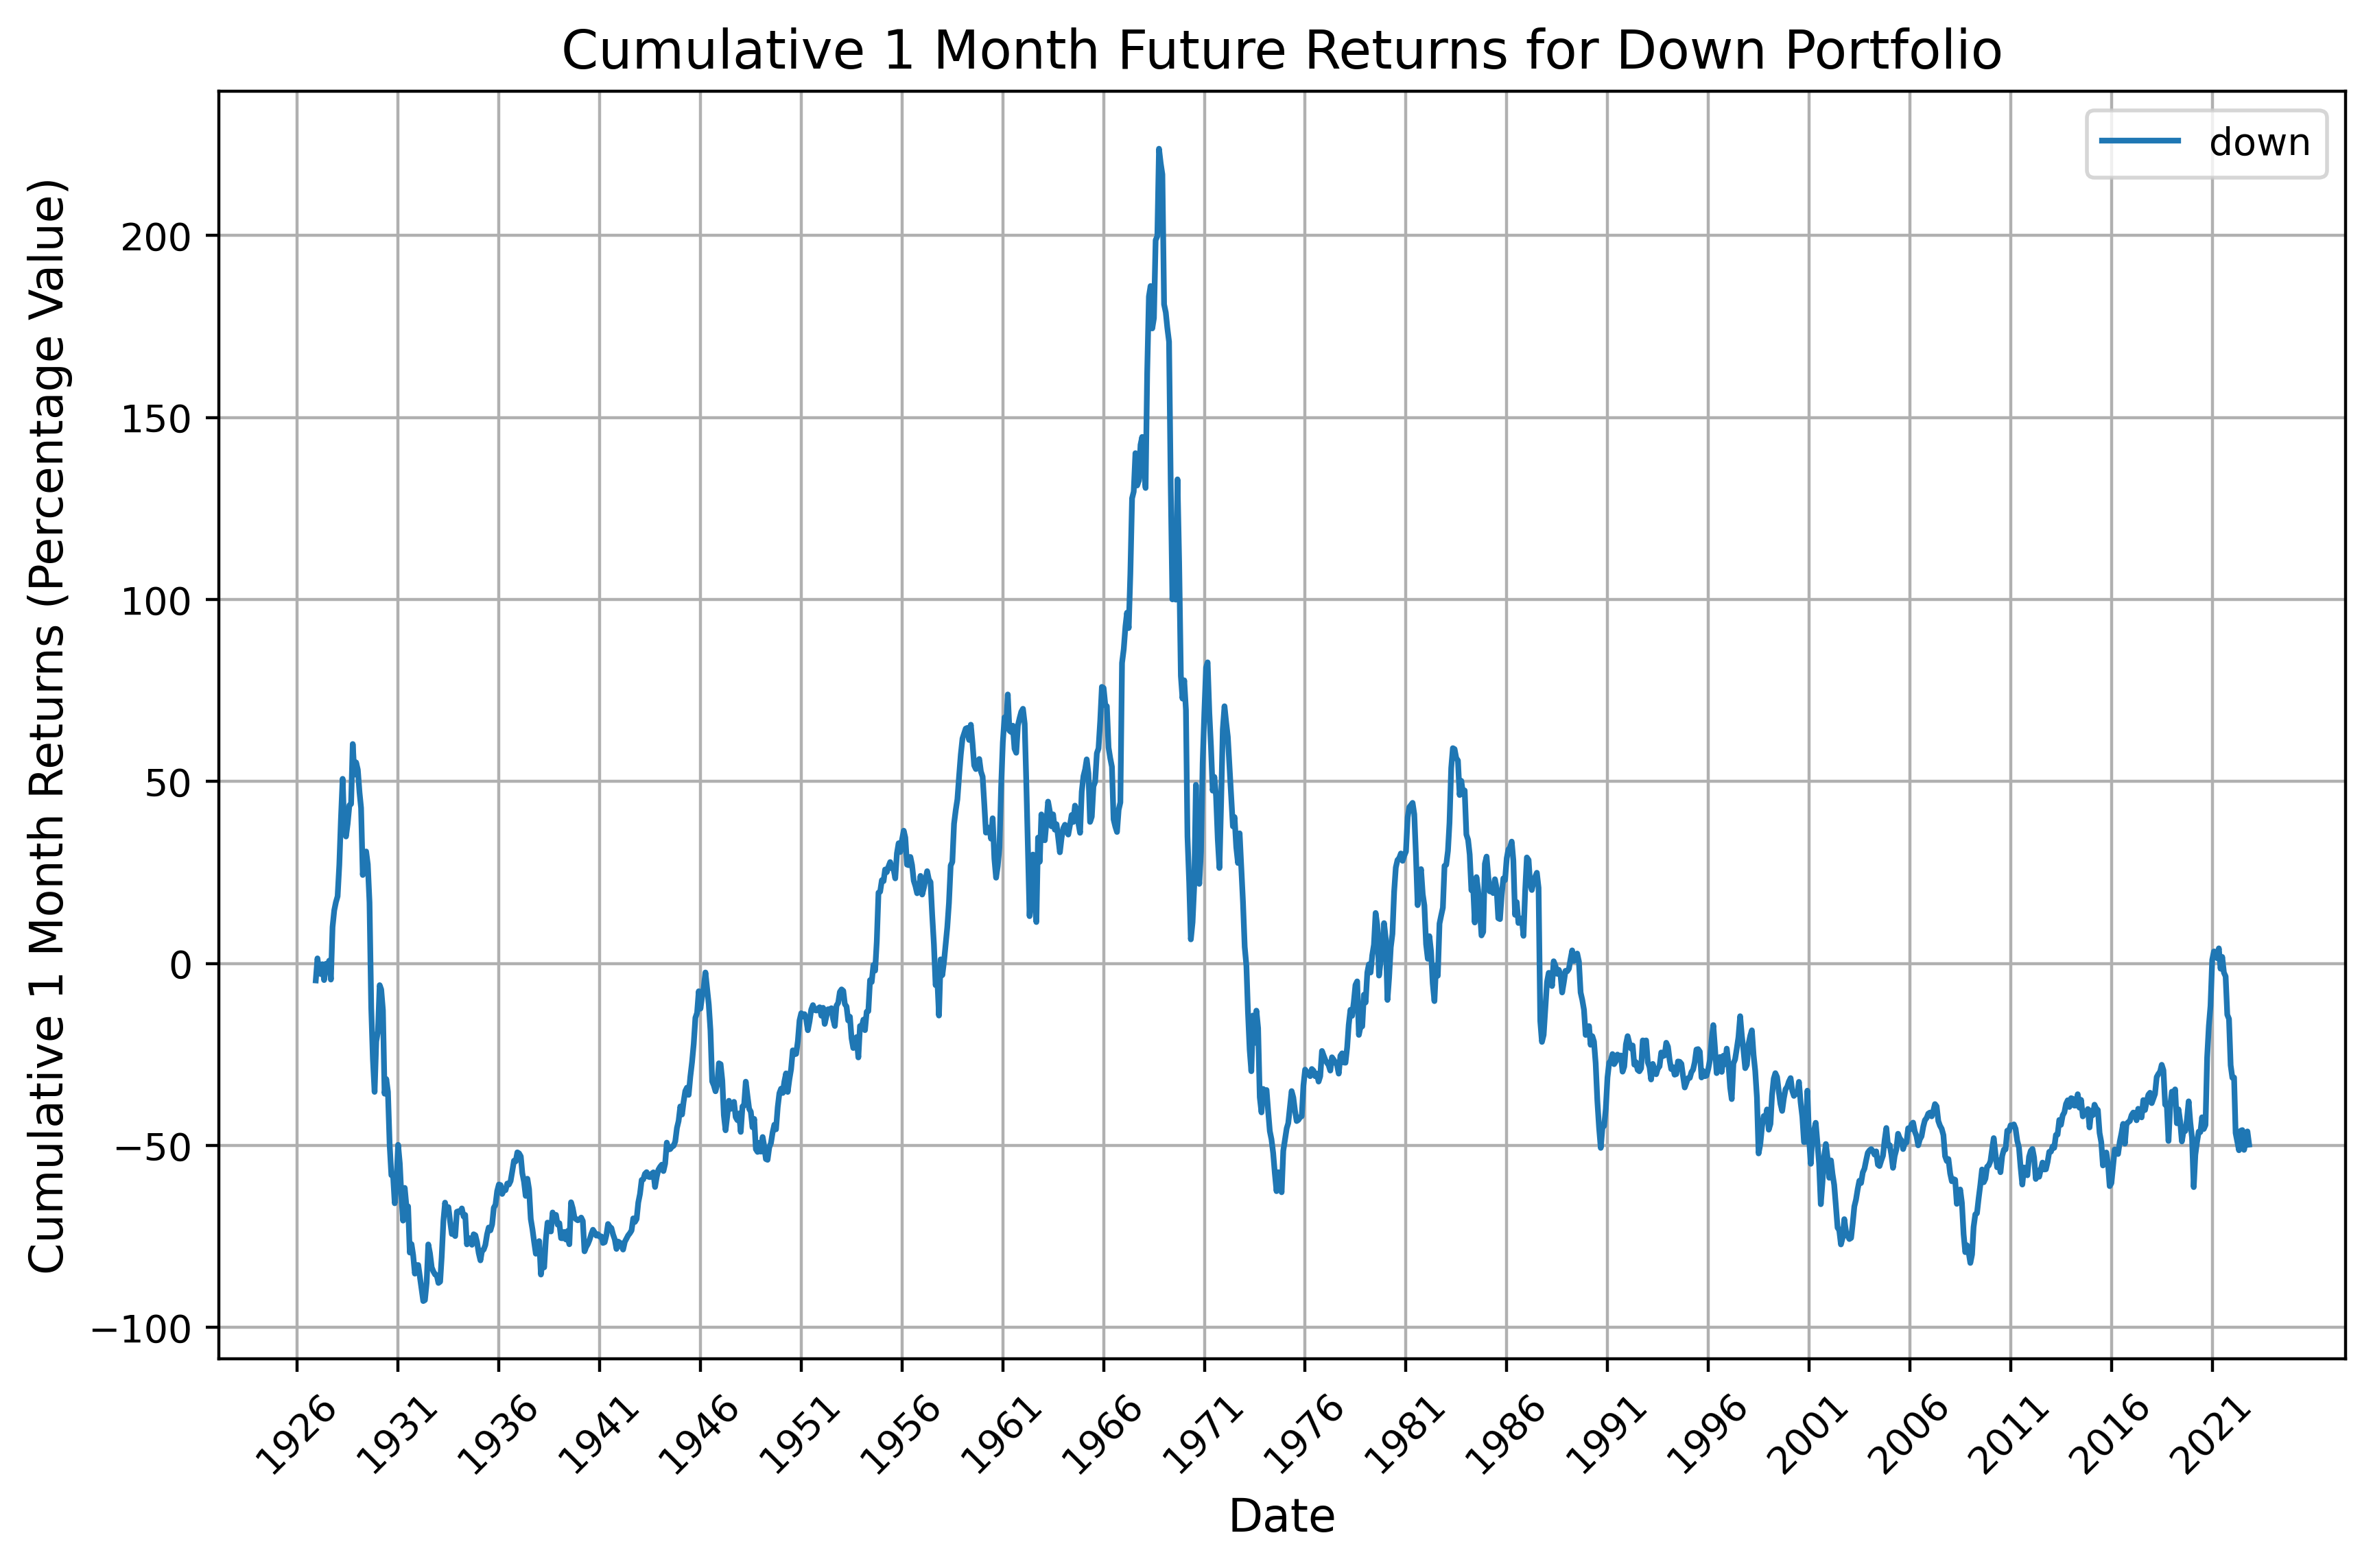

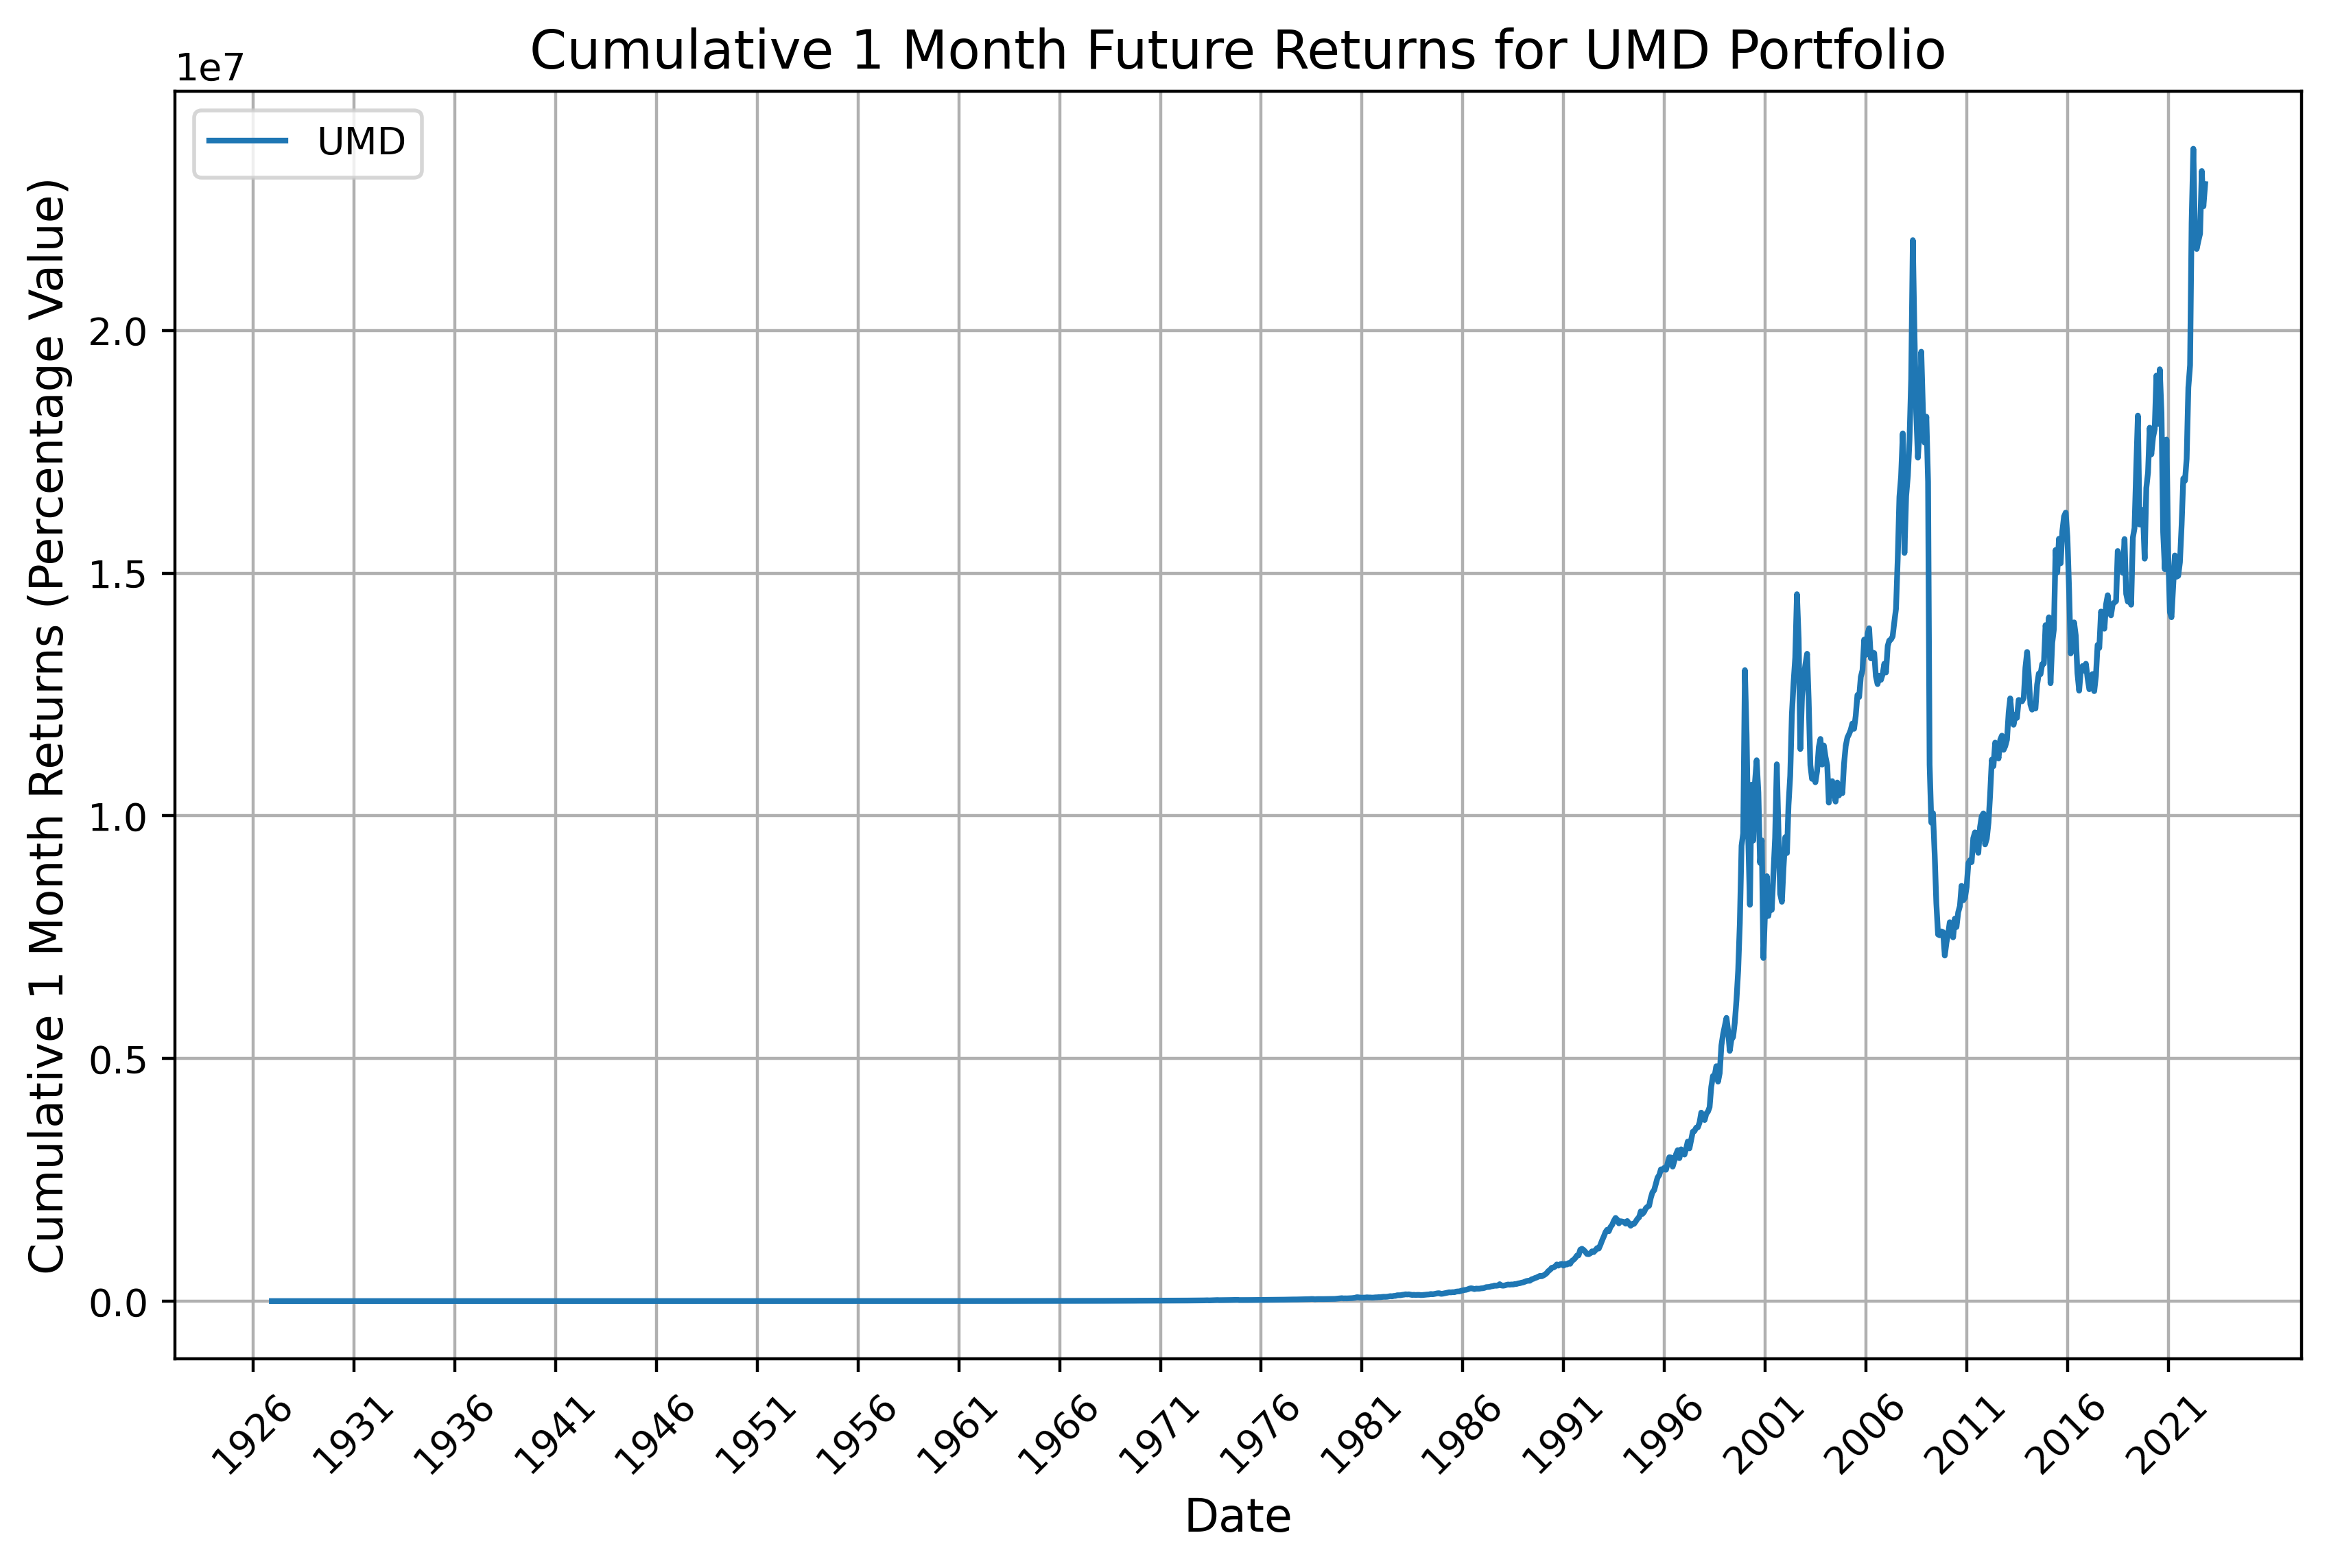

In [68]:
plotDf = reduce(lambda x, y: pd.merge(x, y, 
                                      left_index = True, 
                                      right_index = True, 
                                      how = "outer"),
                [up[["future1MonthRet"]].rename(columns = {"future1MonthRet":"up"}),
                 down[["future1MonthRet"]].rename(columns = {"future1MonthRet":"down"}),
                 UMD[["future1MonthRet"]].rename(columns = {"future1MonthRet":"UMD"})])

plotDf = plotDf.dropna()
plotDf = plotDf + 1
plotDf = plotDf.cumprod() - 1
plotDf = plotDf*100

plotSeriesFromDataFrame(plotDf[["up"]], title="Cumulative 1 Month Future Returns for Up Portfolio", 
                        xLabel="Date", 
                        yLabel="Cumulative 1 Month Returns (Percentage Value)", 
                        legendLoc="best",
                        rotateXTicks = True,
                        legendOutside = False)

plotSeriesFromDataFrame(plotDf[["down"]], title="Cumulative 1 Month Future Returns for Down Portfolio", 
                        xLabel="Date", 
                        yLabel="Cumulative 1 Month Returns (Percentage Value)", 
                        legendLoc="best",
                        rotateXTicks = True,
                        legendOutside = False)

plotSeriesFromDataFrame(plotDf[["UMD"]], title="Cumulative 1 Month Future Returns for UMD Portfolio", 
                        xLabel="Date", 
                        yLabel="Cumulative 1 Month Returns (Percentage Value)", 
                        legendLoc="best",
                        rotateXTicks = True,
                        legendOutside = False)

#### Top 5 Loss Making Months for UMD Portfolio

In [69]:
UMD = UMD[["future1MonthRet"]]
up = up[["future1MonthRet"]]
down = down[["future1MonthRet"]]

lossUMD = UMD.sort_values(by='future1MonthRet', ascending=True)[:5]
lossUMD = lossUMD.merge(up, 
                        left_index = True,
                        right_index = True,
                        how = "left",
                        suffixes = ("_UMD", "_UP"))

header = "### Table 3: Years in Which the 1 Month Momentum Strategy Exhibit Largest Losses for UMD Portfolio and Corresponding Up Portfolio Returns"
display(Markdown(header))
display(lossUMD)

### Table 3: Years in Which the 1 Month Momentum Strategy Exhibit Largest Losses for UMD Portfolio and Corresponding Up Portfolio Returns

,future1MonthRet_UMD,future1MonthRet_UP
date,,
1932-07-01,-0.574938,0.286728
1932-06-01,-0.478939,0.157126
1938-05-01,-0.374695,0.092400
1939-08-01,-0.367525,0.138415
2009-03-01,-0.345324,0.030731


##### The one-month momentum strategy (UMD) incurred its five largest losses during the years 1932 and 1938-1939, as well as in 2009. These years are notably significant in economic history. The year 1932 was amidst the Great Depression, a period of severe worldwide economic downturn, while 1938 and 1939 were marked by a recession within the depression era, and the latter part of 1939 saw the beginning of World War II. These years were characterized by high volatility and economic instability, which often lead to the breakdown of typical financial patterns, such as those exploited by momentum strategies. In 2009, the financial markets were similarly turbulent due to the aftermath of the 2008 global financial crisis, another period of significant economic stress and market volatility.


##### During these tumultuous years, the Up portfolio exhibited positive returns for the respective months, which indicates a divergence from the overall negative momentum strategy performance. This could suggest that even though the momentum strategy as a whole suffered, there were still individual winners that managed to generate positive returns. However, these gains in the Up portfolio were insufficient to offset the losses from the Down component, leading to substantial overall declines in the UMD portfolio. This divergence possibly underscores the complexity of market dynamics during crisis periods, where the typical correlations and expected behaviors between winner and loser stocks may decouple.

#### 3 Year Rolling Window Returns

In [70]:
up = up + 1
down = down + 1
UMD = UMD + 1


up = up.replace(np.nan, 1).rolling(window=36).apply(np.prod, raw=True) - 1
down = down.replace(np.nan, 1).rolling(window=36).apply(np.prod, raw=True) - 1
UMD = UMD.replace(np.nan, 1).rolling(window=36).apply(np.prod, raw=True) - 1

upNegative = up[up["future1MonthRet"]<0] 
downNegative = down[down["future1MonthRet"]<0] 
UMDNegative = UMD[UMD["future1MonthRet"]<0] 



df = pd.DataFrame({"portfolio": ["up", "down", "UMD"],
                   "percentage": [(len(upNegative)*100/len(up)),
                                  (len(downNegative)*100/len(down)),
                                  (len(UMDNegative)*100/len(UMD))]})
df = df.set_index("portfolio")

header = "### Table 4: Percentage of Periods Exhibiting Negative Returns for Up, Down and UMD Portfolios"
display(Markdown(header))
display(df)

### Table 4: Percentage of Periods Exhibiting Negative Returns for Up, Down and UMD Portfolios

,percentage
portfolio,
up,11.621856
down,45.533391
UMD,11.448395
